In [3]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import numpy as np
from googlemaps import Client as GoogleMaps
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsRegressor

In [4]:
warnings.filterwarnings('ignore')

In [5]:
sample = pd.read_csv('SampleSubmission.csv')
sample

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1
...,...,...
1445,8a858fff5a36fe68015a3744f0021e89,1
1446,8aaae7a74400b28201441c8b62514150,1
1447,8aab10f748cf78ff0148d11fac1447a6,1
1448,8aab160f499477da014999ba2f0f578b,1


In [6]:
demographic = pd.read_csv('traindemographics.csv')
demographic.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


Description of demographic data:
- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)


In [7]:
performance = pd.read_csv('trainperf.csv')
performance.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


Performance data (trainperf.csv) : This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict whether this loan would default given all previous loans and demographics of a customer.
Description of data:
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict

In [8]:
previous = pd.read_csv('trainprevloans.csv')
previous.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


Previous loans data (trainprevloans.csv) : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.
Description of data:
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)

In [9]:
customerCheck = demographic.assign(InPerformance=demographic.customerid.isin(performance.customerid), InPrevious=demographic.customerid.isin(previous.customerid))
customerCheck = customerCheck[['customerid','InPerformance','InPrevious']]

In [10]:
demographic.assign(InPerformance=demographic.customerid.isin(performance.customerid), InPrevious=demographic.customerid.isin(previous.customerid))


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,InPerformance,InPrevious
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,True,True
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,True,True
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,True,True
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,True,True
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4341,8a858f155554552501555588ca2b3b40,1985-12-13 00:00:00.000000,Other,3.236753,7.030168,Stanbic IBTC,NaN,Permanent,Graduate,True,True
4342,8a858fc65cf978f4015cf97cee3a02ce,1982-07-01 00:00:00.000000,Savings,7.013750,4.875662,GT Bank,NaN,NaN,NaN,True,True
4343,8a858f4f5b66de3a015b66fc83c61902,1989-09-26 00:00:00.000000,Savings,6.295530,7.092508,GT Bank,NaN,Permanent,NaN,False,False
4344,8aaae7a74400b28201441c8b62514150,1985-09-06 00:00:00.000000,Savings,3.354206,6.539070,GT Bank,HEAD OFFICE,Permanent,Primary,False,False


In [11]:
customerCheck

,customerid,InPerformance,InPrevious
0,8a858e135cb22031015cbafc76964ebd,True,True
1,8a858e275c7ea5ec015c82482d7c3996,True,True
2,8a858e5b5bd99460015bdc95cd485634,True,True
3,8a858efd5ca70688015cabd1f1e94b55,True,True
4,8a858e785acd3412015acd48f4920d04,False,False
...,...,...,...
4341,8a858f155554552501555588ca2b3b40,True,True
4342,8a858fc65cf978f4015cf97cee3a02ce,True,True
4343,8a858f4f5b66de3a015b66fc83c61902,False,False
4344,8aaae7a74400b28201441c8b62514150,False,False


In [12]:
customerCheck.groupby(['InPerformance','InPrevious']).value_counts()

InPerformance  InPrevious  customerid                      
False          False       8a858edd57f790040157ffe9b6ed3fbb    2
                           8a858f965bb63a25015bbf63fd062e2e    2
                           8a858fca5c35df2c015c39ad8695343e    2
                           8a858e625c8d993a015c938f829f77ee    2
                           8a28afc7474813a40147639ec637156b    1
                                                              ..
True           True        8a858e105bd92644015bd9db3a0f3be2    1
                           8a858e105bd92644015bdca43c877d2c    1
                           8a858e105bd92644015bdd2f7a981936    1
                           8a858e105bd92644015bdd374f0d1a3a    1
                           8a858fff5c79144c015c7bdbfc086ce1    1
Length: 4334, dtype: int64

In [13]:
demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4346 non-null   object 
 1   birthdate                   4346 non-null   object 
 2   bank_account_type           4346 non-null   object 
 3   longitude_gps               4346 non-null   float64
 4   latitude_gps                4346 non-null   float64
 5   bank_name_clients           4346 non-null   object 
 6   bank_branch_clients         51 non-null     object 
 7   employment_status_clients   3698 non-null   object 
 8   level_of_education_clients  587 non-null    object 
dtypes: float64(2), object(7)
memory usage: 305.7+ KB


In [14]:
performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


In [15]:
previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [16]:
previous.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [17]:
performance.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [18]:
performance.loc[performance['customerid'] == '8a858e105bd92644015bd9db3a0f3be2']

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
2899,8a858e105bd92644015bd9db3a0f3be2,301981450,3,2017-07-17 09:50:07.000000,2017-07-17 08:50:00.000000,10000.0,13000.0,30,NaN,Good


In [19]:
previous.loc[previous['customerid'] == '8a858e105bd92644015bd9db3a0f3be2']

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
7765,8a858e105bd92644015bd9db3a0f3be2,301940743,2,2017-06-16 10:43:41.000000,2017-06-16 09:43:35.000000,10000.0,13000.0,30,2017-07-15 07:03:02.000000,NaN,2017-07-17 00:00:00.000000,2017-07-15 06:52:53.000000
12030,8a858e105bd92644015bd9db3a0f3be2,301911310,1,2017-05-17 13:00:00.000000,2017-05-17 11:58:51.000000,10000.0,13000.0,30,2017-06-16 10:36:38.000000,NaN,2017-06-16 00:00:00.000000,2017-06-16 10:26:29.000000


In [20]:
duplicate = demographic[demographic.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
159,8a858fca5c35df2c015c39ad8695343e,1980-11-26 00:00:00.000000,Savings,3.352588,7.211089,GT Bank,NaN,Permanent,NaN
517,8a858edd57f790040157ffe9b6ed3fbb,1988-01-18 00:00:00.000000,Other,3.782563,7.171356,First Bank,NaN,Permanent,Secondary
776,8a858f965bb63a25015bbf63fd062e2e,1974-02-25 00:00:00.000000,Savings,3.936366,6.817958,Stanbic IBTC,NaN,Permanent,NaN
1015,8a858fe65675195a015679452588279c,1982-08-01 00:00:00.000000,Savings,7.533646,9.046885,UBA,NaN,Permanent,NaN
1090,8a858e6c5c88d145015c8b9627cd5a48,1979-09-30 00:00:00.000000,Savings,3.367008,6.497313,Sterling Bank,NaN,Permanent,NaN
1188,8a858fc75cd62882015cdaf2f4311b3f,1975-10-27 00:00:00.000000,Savings,7.437607,9.088935,GT Bank,NaN,Permanent,NaN
1480,8a858fe05d421ff4015d4c87d2a21ceb,1983-01-20 00:00:00.000000,Savings,8.526960,12.023015,Skye Bank,NaN,Permanent,NaN
1928,8a858e625c8d993a015c938f829f77ee,1988-12-20 00:00:00.000000,Savings,5.768333,5.561992,First Bank,NaN,Permanent,NaN
1996,8a858ec65cc6352b015cc64525ea0763,1985-01-30 00:00:00.000000,Savings,3.845728,7.411737,GT Bank,NaN,Permanent,NaN
4126,8a858f1e5baffcc9015bb02b505f180d,1983-04-06 00:00:00.000000,Savings,6.969350,4.818535,GT Bank,NaN,Permanent,NaN


In [21]:
demographic.drop_duplicates(inplace=True)

In [22]:
customerCheck = demographic.assign(InPerformance=demographic.customerid.isin(performance.customerid), InPrevious=demographic.customerid.isin(previous.customerid))
customerCheck = customerCheck[['customerid','InPerformance','InPrevious']]

In [23]:
customerCheck.groupby(['InPerformance','InPrevious']).value_counts()


InPerformance  InPrevious  customerid                      
False          False       8a28afc7474813a40147639ec637156b    1
                           8a3735d5518aba7301518ac34413010d    1
                           8a858f465668e3d60156790caa5f49da    1
                           8a858f3d5ab81f53015ab8334351169b    1
                           8a858f3d5add42e2015ae0d08df06d16    1
                                                              ..
True           True        8a858e0f5c45466f015c5469454d1227    1
                           8a858e0f5c45466f015c55c7e09d5e9c    1
                           8a858e105b434e9e015b437dbfab3920    1
                           8a858e105bd92644015bd9db3a0f3be2    1
                           8a858fff5c79144c015c7bdbfc086ce1    1
Length: 4334, dtype: int64

Create the first model which would predict for non-new customers based on demographic and previous loans data.
Create the second model which predict for new customers based on just demographic data.

### Determining how the dataframes are going to be concatenated.

#### Checking the common columns between the data sets

##### customerid

Performance dataframe has 18183 entries and previous has 4368 entries.

In [24]:
performanceids = pd.DataFrame(performance['customerid'])
performanceids

,customerid
0,8a2a81a74ce8c05d014cfb32a0da1049
1,8a85886e54beabf90154c0a29ae757c0
2,8a8588f35438fe12015444567666018e
3,8a85890754145ace015429211b513e16
4,8a858970548359cc0154883481981866
...,...
4363,8a858e6d58b0cc520158beeb14b22a5a
4364,8a858ee85cf400f5015cf44ab1c42d5c
4365,8a858f365b2547f3015b284597147c94
4366,8a858f935ca09667015ca0ee3bc63f51


In [25]:
performanceids.groupby('customerid').value_counts().nlargest()

customerid
8a1088a0484472eb01484669e3ce4e0b    1
8a1a1e7e4f707f8b014f797718316cad    1
8a1a32fc49b632520149c3b8fdf85139    1
8a1eb5ba49a682300149c3c068b806c7    1
8a1edbf14734127f0147356fdb1b1eb2    1
dtype: int64

In [26]:
previousids = pd.DataFrame(previous['customerid'])
previousids

,customerid
0,8a2a81a74ce8c05d014cfb32a0da1049
1,8a2a81a74ce8c05d014cfb32a0da1049
2,8a2a81a74ce8c05d014cfb32a0da1049
3,8a8588f35438fe12015444567666018e
4,8a85890754145ace015429211b513e16
...,...
18178,8a858899538ddb8e0153a2b555421fc5
18179,8a858899538ddb8e0153a2b555421fc5
18180,8a858899538ddb8e0153a2b555421fc5
18181,8a858f0656b7820c0156c92ca3ba436f


In [27]:
previousids.groupby('customerid').value_counts().nlargest()

customerid
8a858f7d5578012a01557ea194d94948    26
8a858e4456ced8470156d73452f85335    22
8a85886f54517ee0015470749d3c3ce7    21
8a85888c548fb3d50154947fe59c32cf    21
8a858899538ddb8e0153a780c56e34bb    21
dtype: int64

From the analysis above, one can see that the most times a customer appears in the performance data is once, whereas the most times a customer appears in the previous data is 26 times. This means there is a one to many relationship between the two dataframes with previous being on the many side. This means it is more ideal to add the 'performance' dataframe to the previous dataframe.

##### adding the performance dataframe to the previous loans dataframe

Between the two dataframes,there are a number of similar columns. To add the two dataframes together, the column names of the incoming dataframe,'performance', will be changed to be able to distinguish the columns.

In [28]:
performance.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

In [29]:
previous.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

From the cells above, we can see the similar columns: 
customerid, systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays and referred by. 
All of these columns,apart from customerid and systemloanid, will be renamed now.
Customerid and systemloanid will not be renamed because they are going to be dropped ahead.

In [30]:
performance.columns = ['customerid','systemloanid','perf_loannumber','perf_approveddate','perf_creationdate','perf_loanamount','perf_totaldue','perf_termdays','perf_referredby','good_bad_flag']

In [31]:
performance.columns

Index(['customerid', 'systemloanid', 'perf_loannumber', 'perf_approveddate',
       'perf_creationdate', 'perf_loanamount', 'perf_totaldue',
       'perf_termdays', 'perf_referredby', 'good_bad_flag'],
      dtype='object')

In [32]:
previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [33]:
previousCustomers = pd.merge(previous, performance, on='customerid')

In [34]:
previousCustomers

,customerid,systemloanid_x,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,...,firstrepaiddate,systemloanid_y,perf_loannumber,perf_approveddate,perf_creationdate,perf_loanamount,perf_totaldue,perf_termdays,perf_referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,...,2016-09-01 15:51:43.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,...,2017-05-26 00:00:00.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,...,2017-04-26 22:03:47.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
3,8a2a81a74ce8c05d014cfb32a0da1049,301923941,10,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,20000.0,24500.0,30,2017-06-25 15:24:06.000000,NaN,...,2017-06-25 15:13:56.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
4,8a2a81a74ce8c05d014cfb32a0da1049,301954468,11,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,20000.0,24500.0,30,2017-07-25 08:14:36.000000,NaN,...,2017-07-25 08:04:27.000000,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18178,8a858f305c8dd672015c92b0711a3333,301941335,1,2017-06-16 18:16:37.000000,2017-06-16 17:15:29.000000,10000.0,11500.0,15,2017-06-26 14:02:03.000000,NaN,...,2017-06-26 13:51:54.000000,301978946,2,2017-07-15 10:42:38.000000,2017-07-15 09:42:24.000000,10000.0,11500.0,15,NaN,Good
18179,8a858fe7568ed7420156920bff565cc7,301955570,1,2017-06-29 01:25:57.000000,2017-06-29 00:25:48.000000,10000.0,11500.0,15,2017-07-05 14:31:17.000000,NaN,...,2017-07-05 14:21:08.000000,301976025,2,2017-07-13 13:07:40.000000,2017-07-13 12:07:32.000000,10000.0,13000.0,30,NaN,Good
18180,8a858f6459b6456d0159b69978f22bed,301796830,1,2017-01-19 14:00:16.000000,2017-01-19 13:00:02.000000,10000.0,11500.0,15,2017-02-15 09:06:34.000000,NaN,...,2017-02-15 08:51:25.000000,301969032,2,2017-07-08 10:12:52.000000,2017-07-08 09:12:37.000000,10000.0,13000.0,30,NaN,Good
18181,8a858fad5ccb633e015ccbe337372ab3,301946936,1,2017-06-21 20:19:29.000000,2017-06-21 19:18:21.000000,10000.0,13000.0,30,2017-07-07 17:08:47.000000,8a858eaa55a0b8ae0155ad2cab5e49cc,...,2017-07-07 16:58:38.000000,301977456,2,2017-07-14 12:00:54.000000,2017-07-14 11:00:48.000000,10000.0,13000.0,30,8a858eaa55a0b8ae0155ad2cab5e49cc,Good


In [35]:
previousCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         18183 non-null  object 
 1   systemloanid_x     18183 non-null  int64  
 2   loannumber         18183 non-null  int64  
 3   approveddate       18183 non-null  object 
 4   creationdate       18183 non-null  object 
 5   loanamount         18183 non-null  float64
 6   totaldue           18183 non-null  float64
 7   termdays           18183 non-null  int64  
 8   closeddate         18183 non-null  object 
 9   referredby         1026 non-null   object 
 10  firstduedate       18183 non-null  object 
 11  firstrepaiddate    18183 non-null  object 
 12  systemloanid_y     18183 non-null  int64  
 13  perf_loannumber    18183 non-null  int64  
 14  perf_approveddate  18183 non-null  object 
 15  perf_creationdate  18183 non-null  object 
 16  perf_loanamount    181

Dropping the systemloanid columns

In [36]:
previousCustomers.drop(['systemloanid_x','systemloanid_y'],axis=1,inplace=True)
previousCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         18183 non-null  object 
 1   loannumber         18183 non-null  int64  
 2   approveddate       18183 non-null  object 
 3   creationdate       18183 non-null  object 
 4   loanamount         18183 non-null  float64
 5   totaldue           18183 non-null  float64
 6   termdays           18183 non-null  int64  
 7   closeddate         18183 non-null  object 
 8   referredby         1026 non-null   object 
 9   firstduedate       18183 non-null  object 
 10  firstrepaiddate    18183 non-null  object 
 11  perf_loannumber    18183 non-null  int64  
 12  perf_approveddate  18183 non-null  object 
 13  perf_creationdate  18183 non-null  object 
 14  perf_loanamount    18183 non-null  float64
 15  perf_totaldue      18183 non-null  float64
 16  perf_termdays      181

In [37]:
previousCustomers = pd.merge(previousCustomers, demographic, on='customerid')

##### adding demographic data to previous customers dataframe

In [38]:
previousCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13673 entries, 0 to 13672
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  13673 non-null  object 
 1   loannumber                  13673 non-null  int64  
 2   approveddate                13673 non-null  object 
 3   creationdate                13673 non-null  object 
 4   loanamount                  13673 non-null  float64
 5   totaldue                    13673 non-null  float64
 6   termdays                    13673 non-null  int64  
 7   closeddate                  13673 non-null  object 
 8   referredby                  800 non-null    object 
 9   firstduedate                13673 non-null  object 
 10  firstrepaiddate             13673 non-null  object 
 11  perf_loannumber             13673 non-null  int64  
 12  perf_approveddate           13673 non-null  object 
 13  perf_creationdate           136

##### looking at the data contained in the columns now to determine what columns will be used to train the model

*columns containing non-numerical data*

In [39]:
categorical = [var for var in previousCustomers.columns if previousCustomers[var].dtype=='O']

print('There are {} categorical variables \n'.format(len(categorical)))

print('They are: ', categorical)

There are 17 categorical variables 

They are:  ['customerid', 'approveddate', 'creationdate', 'closeddate', 'referredby', 'firstduedate', 'firstrepaiddate', 'perf_approveddate', 'perf_creationdate', 'perf_referredby', 'good_bad_flag', 'birthdate', 'bank_account_type', 'bank_name_clients', 'bank_branch_clients', 'employment_status_clients', 'level_of_education_clients']


In [40]:
previousCustomers[categorical].head()

,customerid,approveddate,creationdate,closeddate,referredby,firstduedate,firstrepaiddate,perf_approveddate,perf_creationdate,perf_referredby,good_bad_flag,birthdate,bank_account_type,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a2a81a74ce8c05d014cfb32a0da1049,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate
2,8a2a81a74ce8c05d014cfb32a0da1049,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate
3,8a2a81a74ce8c05d014cfb32a0da1049,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,2017-06-25 15:24:06.000000,NaN,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate
4,8a2a81a74ce8c05d014cfb32a0da1049,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,2017-07-25 08:14:36.000000,NaN,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,NaN,Good,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate


##### customer id column: Primary key used to merge to other data

customer id column has an averagely high cardinality and is used to uniquely identify the customers. This feature will not be used for model training.

##### approved date column : Date that loan was approved

approved date column has a high cardinality. It will not be used because we don't believe the approval data for a loan holds a significance towards whether a loan may be bad or good.

##### creation date column : Date that loan application was created

creation date column has a high cardinality. It will not be selected as feature to train the model because we do not believe the creation date for a loan holds a significance towards whether a loan may be bad or good

##### closed date column : Date that the loan was settled

closed date column has a high cardinality. Since we have a loan creation date, we can arrive at how long the loan was active until it was settled. This time period can then be used as a new feature to train the model. Let's look more at the closed dates and see if there is a relationship  between the closing dates and whether a loan may be good or bad.

In [41]:
closedDates = previousCustomers[['closeddate','good_bad_flag']]
closedDates

,closeddate,good_bad_flag
0,2016-09-01 16:06:48.000000,Good
1,2017-05-28 14:44:49.000000,Good
2,2017-04-26 22:18:56.000000,Good
3,2017-06-25 15:24:06.000000,Good
4,2017-07-25 08:14:36.000000,Good
...,...,...
13668,2017-07-18 16:33:55.000000,Good
13669,2017-07-11 14:26:40.000000,Good
13670,2017-06-26 14:02:03.000000,Good
13671,2017-07-05 14:31:17.000000,Good


 going to break down the date and individual components, ie year, month and day and time. Then proceed to gain insights into the relationship between date/time and bad/good loans

In [42]:
closedDates['closeddate'] = pd.to_datetime(closedDates['closeddate'])

In [43]:
closedDates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13673 entries, 0 to 13672
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   closeddate     13673 non-null  datetime64[ns]
 1   good_bad_flag  13673 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 320.5+ KB


In [44]:
closedDates['year'] = closedDates['closeddate'].dt.year
closedDates.head()

,closeddate,good_bad_flag,year
0,2016-09-01 16:06:48,Good,2016
1,2017-05-28 14:44:49,Good,2017
2,2017-04-26 22:18:56,Good,2017
3,2017-06-25 15:24:06,Good,2017
4,2017-07-25 08:14:36,Good,2017


In [45]:
closedDates['month'] = closedDates['closeddate'].dt.month
closedDates.head()

,closeddate,good_bad_flag,year,month
0,2016-09-01 16:06:48,Good,2016,9
1,2017-05-28 14:44:49,Good,2017,5
2,2017-04-26 22:18:56,Good,2017,4
3,2017-06-25 15:24:06,Good,2017,6
4,2017-07-25 08:14:36,Good,2017,7


In [46]:
closedDates['day'] = closedDates['closeddate'].dt.day
closedDates.head()

,closeddate,good_bad_flag,year,month,day
0,2016-09-01 16:06:48,Good,2016,9,1
1,2017-05-28 14:44:49,Good,2017,5,28
2,2017-04-26 22:18:56,Good,2017,4,26
3,2017-06-25 15:24:06,Good,2017,6,25
4,2017-07-25 08:14:36,Good,2017,7,25


In [47]:
closedDates['hourOfDay'] = closedDates['closeddate'].dt.hour
closedDates.head()

,closeddate,good_bad_flag,year,month,day,hourOfDay
0,2016-09-01 16:06:48,Good,2016,9,1,16
1,2017-05-28 14:44:49,Good,2017,5,28,14
2,2017-04-26 22:18:56,Good,2017,4,26,22
3,2017-06-25 15:24:06,Good,2017,6,25,15
4,2017-07-25 08:14:36,Good,2017,7,25,8


In [48]:
closedDates['hourOfDay'].unique()

array([16, 14, 22, 15,  8, 13, 18, 11,  1,  4,  0, 10, 17, 21, 23,  9, 20,
       12,  5,  6, 19,  7,  3,  2])

the hour is recorded in 24 hour clock which is desirable so we can differentiate between the times i.e 3 in the morning and 3 in the evening.

In [49]:
year_group = closedDates.groupby(['year'])['good_bad_flag'].value_counts()
year_group

year  good_bad_flag
2016  Good             2620
      Bad               522
2017  Good             8526
      Bad              2005
Name: good_bad_flag, dtype: int64

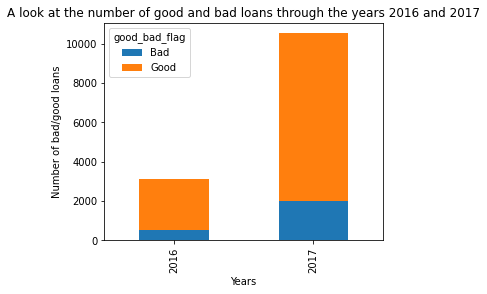

In [50]:

#plt.subplot(4,1,1)
#yearLook = closedDates[['year', 'good_bad_flag']]
closedDates.groupby(['year','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True)
plt.xlabel('Years')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans through the years 2016 and 2017')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(5) 

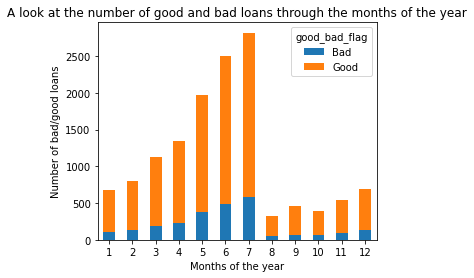

In [51]:
closedDates.groupby(['month','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Months of the year')
plt.ylabel('Number of bad/good loans')
plt.title('A look at the number of good and bad loans through the months of the year')

f = plt.gcf()
f.set_figwidth(5) 

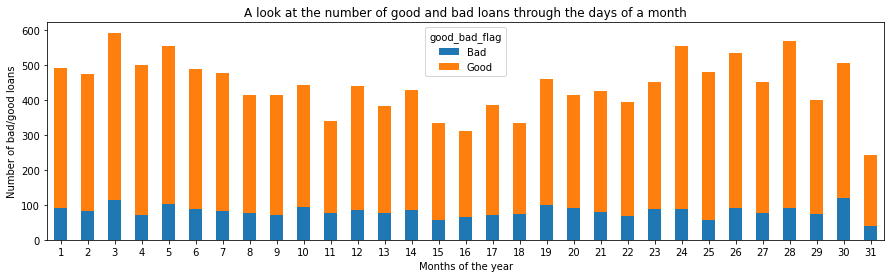

In [52]:
closedDates.groupby(['day','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Months of the year')
plt.ylabel('Number of bad/good loans')
plt.title('A look at the number of good and bad loans through the days of a month')

f = plt.gcf()
f.set_figwidth(15) 

<Figure size 1080x2160 with 0 Axes>

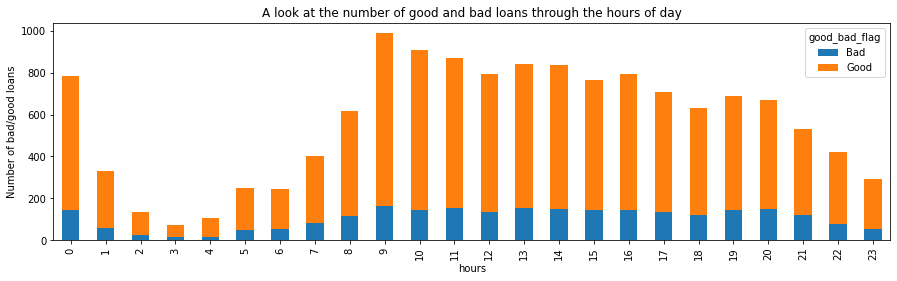

In [53]:
plt.figure(figsize=(15,30))
closedDates.groupby(['hourOfDay','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True)
plt.xlabel('hours')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans through the hours of day')

f = plt.gcf()
f.set_figwidth(15) 

I do not think that the year serves as a significant feature to train this model and therefore it will not be used going forward. The months, day and hour of the day serve as good features to use to train this model.

In [54]:
previousCustomers.head()

,customerid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,...,perf_referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a2a81a74ce8c05d014cfb32a0da1049,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
2,8a2a81a74ce8c05d014cfb32a0da1049,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
3,8a2a81a74ce8c05d014cfb32a0da1049,10,2017-06-01 13:34:30.000000,2017-06-01 12:34:21.000000,20000.0,24500.0,30,2017-06-25 15:24:06.000000,NaN,2017-07-03 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
4,8a2a81a74ce8c05d014cfb32a0da1049,11,2017-06-28 10:58:34.000000,2017-06-28 09:58:25.000000,20000.0,24500.0,30,2017-07-25 08:14:36.000000,NaN,2017-07-31 00:00:00.000000,...,NaN,Good,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate


Let's also look at the duration of the lifetime of the loan i.e from when it was created to when it was fully paid back. 

In [55]:
previousCustomers['closeddate'] = pd.to_datetime(previousCustomers['closeddate'])
previousCustomers['creationdate'] = pd.to_datetime(previousCustomers['creationdate'])

In [56]:
previousCustomers['loanlifewithdelta'] = ((previousCustomers.closeddate - previousCustomers.creationdate)/np.timedelta64(1, 'D'))
previousCustomers['loanlifenodelta'] = previousCustomers.closeddate - previousCustomers.creationdate
previousCustomers.head()

,customerid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,...,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,loanlifewithdelta,loanlifenodelta
0,8a2a81a74ce8c05d014cfb32a0da1049,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14 00:00:00.000000,...,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,16.947407,16 days 22:44:16
1,8a2a81a74ce8c05d014cfb32a0da1049,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30 00:00:00.000000,...,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,29.879120,29 days 21:05:56
2,8a2a81a74ce8c05d014cfb32a0da1049,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04 00:00:00.000000,...,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,52.515706,52 days 12:22:37
3,8a2a81a74ce8c05d014cfb32a0da1049,10,2017-06-01 13:34:30.000000,2017-06-01 12:34:21,20000.0,24500.0,30,2017-06-25 15:24:06,NaN,2017-07-03 00:00:00.000000,...,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,24.117882,24 days 02:49:45
4,8a2a81a74ce8c05d014cfb32a0da1049,11,2017-06-28 10:58:34.000000,2017-06-28 09:58:25,20000.0,24500.0,30,2017-07-25 08:14:36,NaN,2017-07-31 00:00:00.000000,...,1972-01-15 00:00:00.000000,Other,3.43201,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,26.927905,26 days 22:16:11


We will use the loanlifewithdelta column as a new feature to train our model with

In [57]:
previousCustomers.drop(['loanlifenodelta'],axis=1, inplace=True)

We are going to list out the columns that have been selected to train our model to keep track of them as the notebook progresses:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]

##### referredby column

In [58]:
previousCustomers['referredby'].isnull().sum()

12873

In [59]:
len(previousCustomers['referredby'].unique())

408

In [60]:
previousCustomers['referredby'].unique()

array([nan, '8a858ff85bd93919015bda56605652bd',
       '8a858edc59ee87640159eeb9774f1aa7',
       '8a858fc55b2548dd015b286e452c678c',
       '8a858eba5c884d2a015c8bea59385157',
       '8a858e185b4923b4015b536354895cae',
       '8a858fd85b685607015b7ba5638674c0',
       '8a858f9f5bd99987015be3f53cb442d9',
       '8a858fee5800e000015805aae2fe4ef8',
       '8a858fdc57ab280a0157b277e9ff6d53',
       '8a858e645755e62201575e72c8b77fd5',
       '8a858edb5ad79cc6015ad7c9b29415c8',
       '8a858f975c4582c4015c54619e9b7e2b',
       '8a858e6f5bce1023015bce19dbbf038d',
       '8a858f1b5b9136f7015b9f66e5c5327c',
       '8a858e7855113fb701551fe018ce6913',
       '8a858fa3551e78cb01552596fed60cec',
       '8a858eda5c8863ff015c8b96e5fd74d0',
       '8a858ed75732b681015744c9dee21aae',
       '8a858f1e5aec5791015aef876abb0dbc',
       '8a858fa75b5c94ed015b5c9d50890bb4',
       '8a8589ac53a917ed0153a9f9e614244b',
       '8a858f475c7ea023015c81ad999a0386',
       '8a858e5b5bd99460015bd9e9ee2e18f4',
      

The referredby column has a high cardinality and the column value doesn't particularly give any relevance to the model. The details of the referee may be useful though and so will be considered.

##### first_due_date and first_repaid_date columns

This columns individually don't provide significant features but when used together might prove to be more useful.
The difference between the two columns can tell us if a customer was prompt on making their payments.

In [61]:
loanrepayment = previousCustomers[['firstduedate','firstrepaiddate','good_bad_flag']]

In [62]:
loanrepayment.head()

,firstduedate,firstrepaiddate,good_bad_flag
0,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,Good
1,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,Good
2,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,Good
3,2017-07-03 00:00:00.000000,2017-06-25 15:13:56.000000,Good
4,2017-07-31 00:00:00.000000,2017-07-25 08:04:27.000000,Good


In [63]:
loanrepayment['firstduedate'] = pd.to_datetime(loanrepayment['firstduedate'])
loanrepayment['firstrepaiddate'] = pd.to_datetime(loanrepayment['firstrepaiddate'])

In [64]:
loanrepayment['firstrepaymentlapsewithdelta'] = ((loanrepayment.firstduedate - loanrepayment.firstrepaiddate)/np.timedelta64(1, 'D'))
loanrepayment['firstrepaymentlapsewithnodelta'] = loanrepayment.firstduedate - loanrepayment.firstrepaiddate
loanrepayment.head()

,firstduedate,firstrepaiddate,good_bad_flag,firstrepaymentlapsewithdelta,firstrepaymentlapsewithnodelta
0,2016-09-14,2016-09-01 15:51:43,Good,12.339086,12 days 08:08:17
1,2017-05-30,2017-05-26 00:00:00,Good,4.000000,4 days 00:00:00
2,2017-04-04,2017-04-26 22:03:47,Good,-22.919294,-23 days +01:56:13
3,2017-07-03,2017-06-25 15:13:56,Good,7.365324,7 days 08:46:04
4,2017-07-31,2017-07-25 08:04:27,Good,5.663576,5 days 15:55:33


Updating selected features:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]

In [65]:
##thinking of having a column showing the days and another column saying whether it was before or after the due date

The next cells are looking at the data from the performance dataframe. Those columns that were also present in the previous dataframe and were dropped as features above, will also be dropped as features below. 

##### perf_referredby

In [66]:
len(previousCustomers['perf_referredby'].unique())

408

In [67]:
previousCustomers['perf_referredby'].isnull().sum()

12873

There are a number of null values within this columns and we cannot easily replace the missing values. This column will therefore not be used going forward

##### birthdate

This column may not be significant as it is for training our model. It may be better to get the actual age of the customers rather than using there birthdates.

So let us get the actual ages of the customers.

In [68]:
#converting birthdate column to datetime
previousCustomers['birthdate'] = pd.to_datetime(previousCustomers['birthdate'])

In [69]:
customerAge = previousCustomers[['birthdate','good_bad_flag']]
customerAge.head()

,birthdate,good_bad_flag
0,1972-01-15,Good
1,1972-01-15,Good
2,1972-01-15,Good
3,1972-01-15,Good
4,1972-01-15,Good


In [70]:
currentDate = date.today()

In [71]:
currentDate

datetime.date(2022, 12, 11)

In [72]:
customerAge['age'] = round(((pd.datetime.now()- customerAge['birthdate'])/np.timedelta64(1, 'Y')),1)

In [73]:
customerAge.tail()

,birthdate,good_bad_flag,age
13668,1986-02-20,Good,36.8
13669,1979-04-18,Good,43.7
13670,1989-11-19,Good,33.1
13671,1980-11-12,Good,42.1
13672,1989-10-24,Good,33.1


In [74]:
customerAge.loc[customerAge['good_bad_flag']=='Good','flag'] = 0
customerAge.loc[customerAge['good_bad_flag']=='Bad','flag'] = 1
customerAge.head()

,birthdate,good_bad_flag,age,flag
0,1972-01-15,Good,50.9,0.0
1,1972-01-15,Good,50.9,0.0
2,1972-01-15,Good,50.9,0.0
3,1972-01-15,Good,50.9,0.0
4,1972-01-15,Good,50.9,0.0


In [75]:
badLoans = customerAge.loc[customerAge['good_bad_flag'] == 'Bad']

In [76]:
badLoans.to_csv('agesAndBadLoans.csv')

In [77]:
customerAge.to_csv('allLoansAndAges.csv')

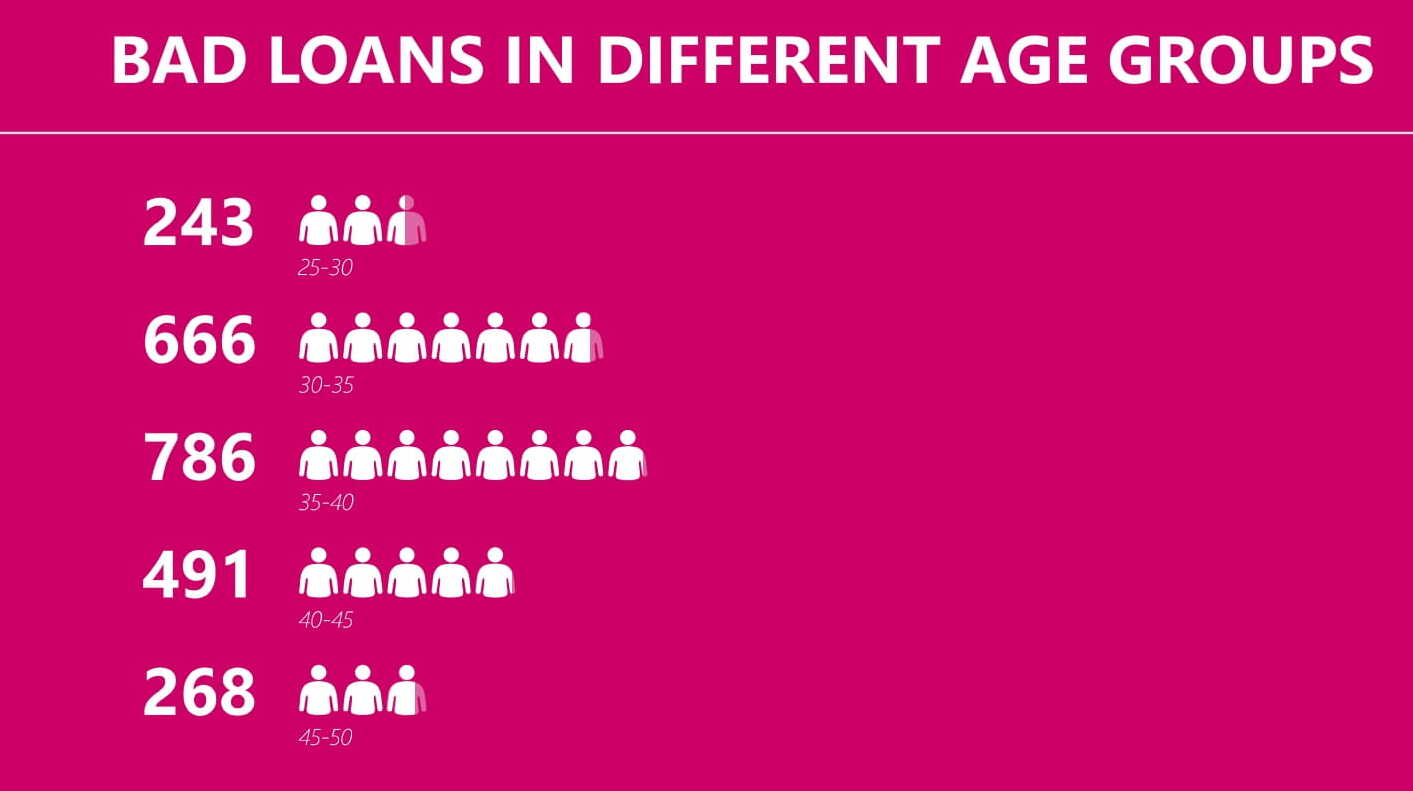

add graph showing good loans

so we shall use the ages of people to train our model instead of their birthdate

Updating selected features:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
3. ages of the customers: birthdate[age]

##### bank account type

In [78]:
len(previousCustomers['bank_account_type'].unique())

3

In [79]:
testdemo = pd.read_csv('testdemographics.csv')

In [80]:
len(testdemo['bank_account_type'].unique())

3

In [81]:
previousCustomers['bank_account_type'].isnull().sum()

0

In [82]:
previousCustomers['bank_account_type'].unique()

array(['Other', 'Savings', 'Current'], dtype=object)

This feature shall be used to train our model

Updating selected features:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
3. ages of the customers: birthdate[age]
4. the type of bank account: previousCustomers[bank_account_type]

##### bank_name_clients

In [83]:
previousCustomers['bank_name_clients'].unique()

array(['Diamond Bank', 'EcoBank', 'First Bank', 'GT Bank', 'UBA',
       'Union Bank', 'FCMB', 'Access Bank', 'Zenith Bank',
       'Fidelity Bank', 'Stanbic IBTC', 'Skye Bank', 'Sterling Bank',
       'Wema Bank', 'Keystone Bank', 'Unity Bank', 'Heritage Bank',
       'Standard Chartered'], dtype=object)

In [84]:
len(previousCustomers['bank_name_clients'].unique())

18

In [85]:
previousCustomers['bank_name_clients'].isnull().sum()

0

In [86]:
len(testdemo['bank_name_clients'].unique())

18

This column will be used to train the model

Updating selected features:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
3. ages of the customers: birthdate[age]
4. the type of bank account: previousCustomers[bank_account_type]
5. the bank name of the clients: previousCustomers[bank_name_clients]

We can also have a look the bad loans and good loans according to the different banks

In [87]:
bankStats = previousCustomers[['bank_name_clients','good_bad_flag']]

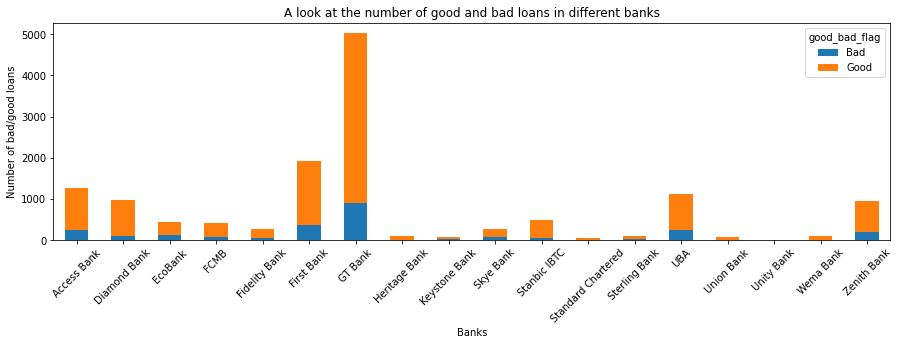

In [88]:

#plt.subplot(4,1,1)
#yearLook = closedDates[['year', 'good_bad_flag']]
bankStats.groupby(['bank_name_clients','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=45)
plt.xlabel('Banks')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans in different banks')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(15) 

In [89]:
# FIND THE AGE RANGE OF THE PEOPLE WHO ARE GOING TO THE DIFFERENT BANKS,
#use pivot table and see the most common bank in the 
#age range and see if there's a connection

##### bank branch clients

In [90]:
previousCustomers['bank_branch_clients'].unique()

array([nan, 'OBA ADEBIMPE', 'RING ROAD', 'AKUTE', 'OGBA',
       'ADEOLA HOPEWELL', 'ABEOKUTA', 'OJUELEGBA', 'LAGOS',
       'OBA AKRAN BERGER PAINT',
       'ACCESS BANK PLC, CHALLENGE ROUNDABOUT IBADAN, OYO STATE.',
       'BOSSO ROAD, MINNA',
       'PLOT 999C DANMOLE STREET, ADEOLA ODEKU, VICTORIA ISLAND, LAGOS',
       'MAFOLUKU', '17, SANUSI FAFUNWA STREET, VICTORIA ISLAND, LAGOS',
       'TRANS AMADI', 'APAPA', 'MUSHIN BRANCH', 'OAU ILE IFE',
       ' IDI - ORO MUSHIN', 'AJOSE ADEOGUN', 'TINCAN', 'ABULE EGBA',
       'OBA AKRAN', 'STERLING BANK PLC 102, IJU ROAD, IFAKO BRANCH',
       'LEKKI EPE', 'OGUDU, OJOTA', 'AKURE BRANCH',
       '40,SAPELE ROAD ,OPPOSITE DUMAZ JUNCTION BENIN CITY EDO STATE.'],
      dtype=object)

In [91]:
previousCustomers['bank_branch_clients'].isnull().sum()

13569

This column will not be used to train our model

##### employment status clients

In [92]:
previousCustomers['employment_status_clients'].unique()

array(['Permanent', nan, 'Self-Employed', 'Student', 'Unemployed',
       'Retired', 'Contract'], dtype=object)

In [93]:
testdemo['employment_status_clients'].unique()

array(['Permanent', 'Self-Employed', nan, 'Student', 'Contract',
       'Unemployed', 'Retired'], dtype=object)

In [94]:
previousCustomers['employment_status_clients'].isnull().sum()

1363

Updating selected features:
1. closed date month: closedDates[month]
2. closed date day: closedDates[day]
3. closed date hour of day: closedDates[hourOfDay]
4. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
5. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
6. ages of the customers: birthdate[age]
7. the type of bank account: previousCustomers[bank_account_type]
8. the bank name of the clients: previousCustomers[bank_name_clients]
9. the employment status of clients: previousCustomers[employment_status]

We can also see how the number of bad and good loans relates to a person's employment status

In [95]:
jobstatus = previousCustomers[['employment_status_clients','good_bad_flag']]

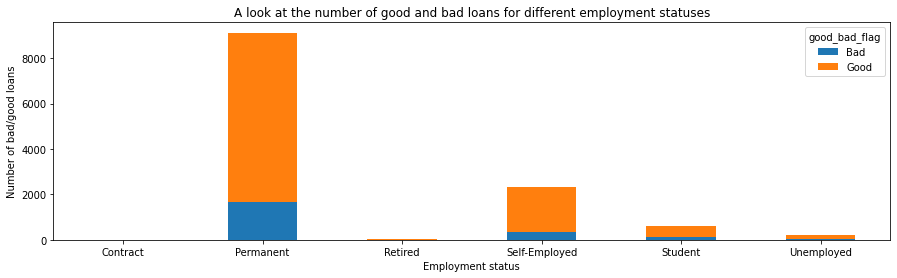

In [96]:

#plt.subplot(4,1,1)
#yearLook = closedDates[['year', 'good_bad_flag']]
jobstatus.groupby(['employment_status_clients','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Employment status')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans for different employment statuses')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(15) 

##### level of education of clients

In [97]:
previousCustomers['level_of_education_clients'].unique()

array(['Post-Graduate', nan, 'Primary', 'Graduate', 'Secondary'],
      dtype=object)

In [98]:
previousCustomers['level_of_education_clients'].isnull().sum()

10209

The number of uneducated Nigerians is actually large and therefore it is safe to assume those that have no level of education selected are not. Therefore the missing values will be replaced with No-Education-Level

In [99]:
previousCustomers['level_of_education_clients'].fillna('No-Education-Level', inplace=True)

Updating selected features:
1. closed date month: closedDates[month]
2. closed date day: closedDates[day]
3. closed date hour of day: closedDates[hourOfDay]
4. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
5. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
6. ages of the customers: birthdate[age]
7. the type of bank account: previousCustomers[bank_account_type]
8. the bank name of the clients: previousCustomers[bank_name_clients]
9. the employment status of clients: previousCustomers[employment_status]
10. the level of education of clients: previousCustomers[level_of_education_clients]

We can still look at the how the level of education plays out in the matter of bad and good loans

In [100]:
educationlevel = previousCustomers[['level_of_education_clients','good_bad_flag']]

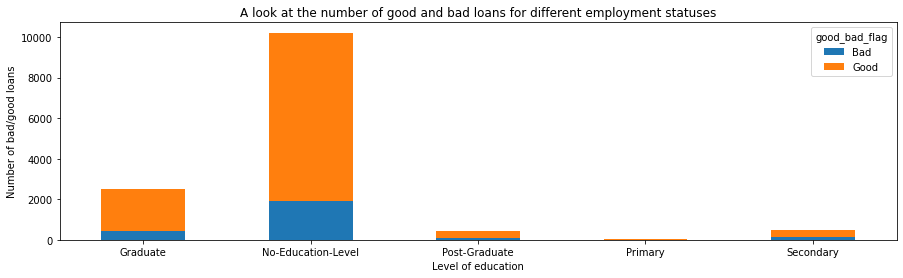

In [101]:

#plt.subplot(4,1,1)
#yearLook = closedDates[['year', 'good_bad_flag']]
educationlevel.groupby(['level_of_education_clients','good_bad_flag']).size().unstack().plot(kind='bar',stacked=True,rot=0)
plt.xlabel('Level of education')
plt.ylabel('Number of bad/good loans')

plt.title('A look at the number of good and bad loans for different employment statuses')

#plt.subplot(4,1,2)
#plt.title('A look at the number of good and bad loans throughout the years')

f = plt.gcf()
f.set_figwidth(15) 

So we have gone through the non-numerical features of our data and have selected the following columns as features to train our model with:
1. period take to settle the loan(lifetime of loan): previousCustomers[loanlifewithdelta]
2. first repayment day status: loanrepayment[firstrepaymentlapsewithdelta]
3. ages of the customers: birthdate[age]
4. the type of bank account: previousCustomers[bank_account_type]
5. the bank name of the clients: previousCustomers[bank_name_clients]
6. the level of education of clients: previousCustomers[level_of_education_clients]

#### Now to look at the numerical columns

In [102]:
numerical = [var for var in previousCustomers.columns if previousCustomers[var].dtype!='O']

print('There are {} numerical variabes \n'.format(len(numerical)))

print('They are: ', numerical)

There are 14 numerical variabes 

They are:  ['loannumber', 'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate', 'perf_loannumber', 'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'birthdate', 'longitude_gps', 'latitude_gps', 'loanlifewithdelta']


We are going to ignore creationdate, closeddate, birthdate, loanlifewithdelta and loanlifewithnodelata as these have been dealt with and discussed while looking at the categorical features.

In [103]:
numColumns= previousCustomers[['loannumber','loanamount','totaldue','termdays','closeddate','perf_loannumber','perf_loanamount','perf_totaldue','perf_termdays','longitude_gps','latitude_gps']]

In [104]:
numColumns.head()

,loannumber,loanamount,totaldue,termdays,closeddate,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,longitude_gps,latitude_gps
0,2,10000.0,13000.0,30,2016-09-01 16:06:48,12,30000.0,34500.0,30,3.43201,6.433055
1,9,10000.0,13000.0,30,2017-05-28 14:44:49,12,30000.0,34500.0,30,3.43201,6.433055
2,8,20000.0,23800.0,30,2017-04-26 22:18:56,12,30000.0,34500.0,30,3.43201,6.433055
3,10,20000.0,24500.0,30,2017-06-25 15:24:06,12,30000.0,34500.0,30,3.43201,6.433055
4,11,20000.0,24500.0,30,2017-07-25 08:14:36,12,30000.0,34500.0,30,3.43201,6.433055


Below we add some of the numerical columns generated from the categorical features. These added columns are going to be treated as numerical i.e a person's age, the lifetime of a loan, the time a person took to complete the first repayment day.

In [105]:
numColumns = pd.concat([numColumns, customerAge['age'],previousCustomers['loanlifewithdelta'],loanrepayment['firstrepaymentlapsewithdelta'],previousCustomers['good_bad_flag']],axis=1)

In [106]:
numColumns.tail()

,loannumber,loanamount,totaldue,termdays,closeddate,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,longitude_gps,latitude_gps,age,loanlifewithdelta,firstrepaymentlapsewithdelta,good_bad_flag
13668,1,10000.0,11500.0,15,2017-07-18 16:33:55,2,10000.0,11500.0,15,5.252457,12.991440,36.8,2.231736,12.316840,Good
13669,1,10000.0,13000.0,30,2017-07-11 14:26:40,2,10000.0,13000.0,30,7.478858,9.055714,43.7,27.359097,2.405197,Good
13670,1,10000.0,11500.0,15,2017-06-26 14:02:03,2,10000.0,11500.0,15,3.381677,6.455923,33.1,9.865671,6.422292,Good
13671,1,10000.0,11500.0,15,2017-07-05 14:31:17,2,10000.0,13000.0,30,6.979660,4.879515,42.1,6.587141,8.401991,Good
13672,1,10000.0,11500.0,15,2017-02-15 09:06:34,2,10000.0,13000.0,30,7.530892,9.042928,33.1,26.837870,-12.369039,Good


In [107]:
numColumns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13673 entries, 0 to 13672
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   loannumber                    13673 non-null  int64         
 1   loanamount                    13673 non-null  float64       
 2   totaldue                      13673 non-null  float64       
 3   termdays                      13673 non-null  int64         
 4   closeddate                    13673 non-null  datetime64[ns]
 5   perf_loannumber               13673 non-null  int64         
 6   perf_loanamount               13673 non-null  float64       
 7   perf_totaldue                 13673 non-null  float64       
 8   perf_termdays                 13673 non-null  int64         
 9   longitude_gps                 13673 non-null  float64       
 10  latitude_gps                  13673 non-null  float64       
 11  age                         

In [108]:
numColumns.drop(['closeddate'],axis=1,inplace=True)

From the first repayment lapse column, we are going to create two new columns:
1. The first, LateFirstPay, will show whether someone was late in making the first repayment date and by how many days
2. The second, EarlyFirstPay, will show whether someone was early in making the first repayment date and by how many days


In [109]:
numColumns.loc[numColumns['firstrepaymentlapsewithdelta'] < 0, 'LateFirstPay'] = numColumns['firstrepaymentlapsewithdelta']
numColumns.loc[numColumns['firstrepaymentlapsewithdelta'] < 0, 'EarlyFirstPay'] = 0
numColumns.loc[numColumns['firstrepaymentlapsewithdelta'] >= 0, 'LateFirstPay'] = 0
numColumns.loc[numColumns['firstrepaymentlapsewithdelta'] >= 0, 'EarlyFirstPay'] = numColumns['firstrepaymentlapsewithdelta']

In [110]:
numColumns

,loannumber,loanamount,totaldue,termdays,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,longitude_gps,latitude_gps,age,loanlifewithdelta,firstrepaymentlapsewithdelta,good_bad_flag,LateFirstPay,EarlyFirstPay
0,2,10000.0,13000.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,16.947407,12.339086,Good,0.000000,12.339086
1,9,10000.0,13000.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,29.879120,4.000000,Good,0.000000,4.000000
2,8,20000.0,23800.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,52.515706,-22.919294,Good,-22.919294,0.000000
3,10,20000.0,24500.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,24.117882,7.365324,Good,0.000000,7.365324
4,11,20000.0,24500.0,30,12,30000.0,34500.0,30,3.432010,6.433055,50.9,26.927905,5.663576,Good,0.000000,5.663576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,1,10000.0,11500.0,15,2,10000.0,11500.0,15,5.252457,12.991440,36.8,2.231736,12.316840,Good,0.000000,12.316840
13669,1,10000.0,13000.0,30,2,10000.0,13000.0,30,7.478858,9.055714,43.7,27.359097,2.405197,Good,0.000000,2.405197
13670,1,10000.0,11500.0,15,2,10000.0,11500.0,15,3.381677,6.455923,33.1,9.865671,6.422292,Good,0.000000,6.422292
13671,1,10000.0,11500.0,15,2,10000.0,13000.0,30,6.979660,4.879515,42.1,6.587141,8.401991,Good,0.000000,8.401991


In [111]:
numColumns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13673 entries, 0 to 13672
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loannumber                    13673 non-null  int64  
 1   loanamount                    13673 non-null  float64
 2   totaldue                      13673 non-null  float64
 3   termdays                      13673 non-null  int64  
 4   perf_loannumber               13673 non-null  int64  
 5   perf_loanamount               13673 non-null  float64
 6   perf_totaldue                 13673 non-null  float64
 7   perf_termdays                 13673 non-null  int64  
 8   longitude_gps                 13673 non-null  float64
 9   latitude_gps                  13673 non-null  float64
 10  age                           13673 non-null  float64
 11  loanlifewithdelta             13673 non-null  float64
 12  firstrepaymentlapsewithdelta  13673 non-null  float64
 13  g

In [112]:
numColumns.drop(['firstrepaymentlapsewithdelta'], axis=1, inplace=True)

Let's have a look at if there are outliers in our data using boxplot

Text(0, 0.5, 'Age')

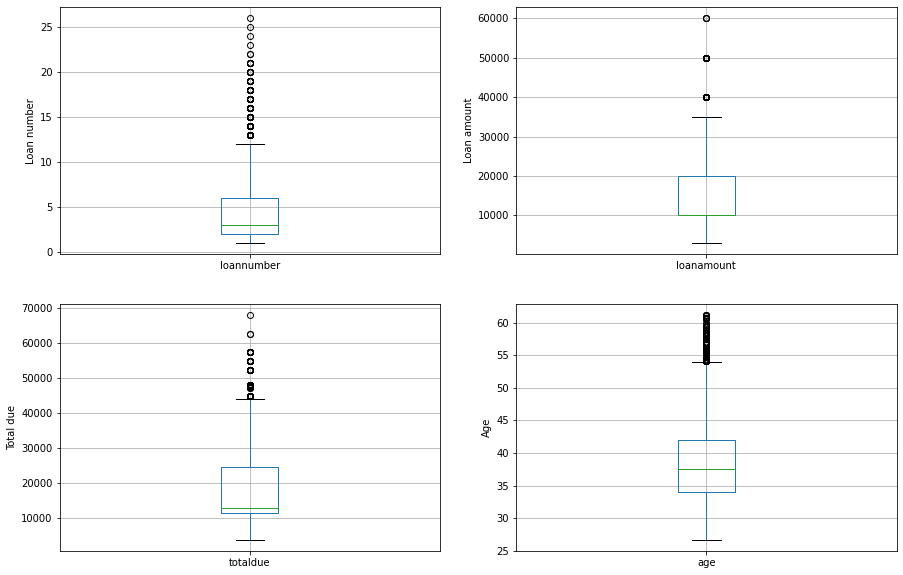

In [113]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = numColumns.boxplot(column='loannumber')
fig.set_ylabel('Loan number')

plt.subplot(2,2,2)
fig = numColumns.boxplot(column='loanamount')
fig.set_ylabel('Loan amount')

plt.subplot(2,2,3)
fig = numColumns.boxplot(column='totaldue')
fig.set_ylabel('Total due')

plt.subplot(2,2,4)
fig = numColumns.boxplot(column='age')
fig.set_ylabel('Age')

Text(0, 0.5, 'Longitude')

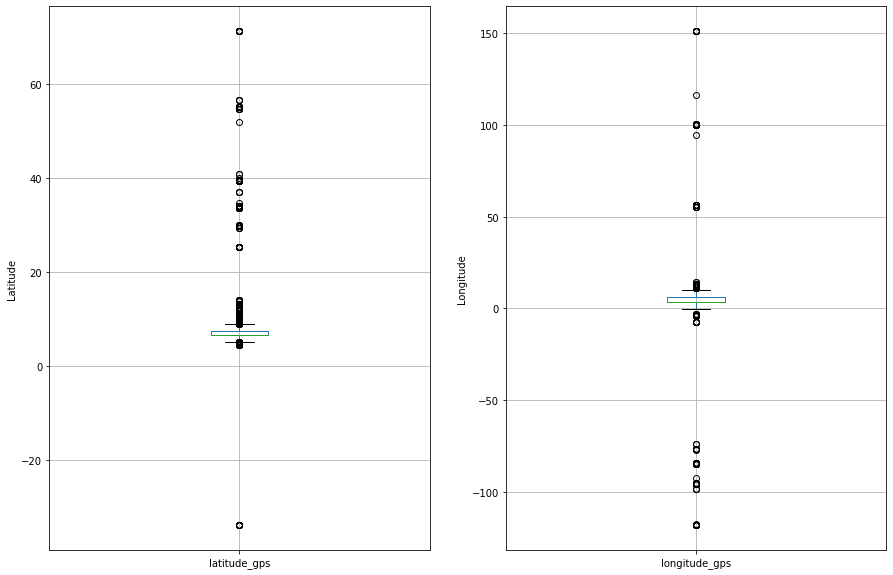

In [114]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
fig = numColumns.boxplot(column='latitude_gps')
fig.set_ylabel('Latitude')

plt.subplot(1,2,2)
fig = numColumns.boxplot(column='longitude_gps')
fig.set_ylabel('Longitude')



The outliers via longitude and latitude may be atttibuted to people who are outside Nigeria.

More Eda can be done via the latitude and longitude

##### splitting data into target and feature

In [115]:
newdf = pd.concat([numColumns, 
                  pd.get_dummies(previousCustomers.bank_account_type),
                  pd.get_dummies(previousCustomers.bank_name_clients),
                  pd.get_dummies(previousCustomers.employment_status_clients),
                  pd.get_dummies(previousCustomers.level_of_education_clients)], axis=1)

newdf

,loannumber,loanamount,totaldue,termdays,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,longitude_gps,latitude_gps,...,Permanent,Retired,Self-Employed,Student,Unemployed,Graduate,No-Education-Level,Post-Graduate,Primary,Secondary
0,2,10000.0,13000.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
1,9,10000.0,13000.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
2,8,20000.0,23800.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
3,10,20000.0,24500.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
4,11,20000.0,24500.0,30,12,30000.0,34500.0,30,3.432010,6.433055,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,1,10000.0,11500.0,15,2,10000.0,11500.0,15,5.252457,12.991440,...,1,0,0,0,0,0,1,0,0,0
13669,1,10000.0,13000.0,30,2,10000.0,13000.0,30,7.478858,9.055714,...,1,0,0,0,0,0,1,0,0,0
13670,1,10000.0,11500.0,15,2,10000.0,11500.0,15,3.381677,6.455923,...,1,0,0,0,0,0,1,0,0,0
13671,1,10000.0,11500.0,15,2,10000.0,13000.0,30,6.979660,4.879515,...,0,0,0,0,1,1,0,0,0,0


In [116]:
newdf.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'perf_loannumber',
       'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'longitude_gps',
       'latitude_gps', 'age', 'loanlifewithdelta', 'good_bad_flag',
       'LateFirstPay', 'EarlyFirstPay', 'Current', 'Other', 'Savings',
       'Access Bank', 'Diamond Bank', 'EcoBank', 'FCMB', 'Fidelity Bank',
       'First Bank', 'GT Bank', 'Heritage Bank', 'Keystone Bank', 'Skye Bank',
       'Stanbic IBTC', 'Standard Chartered', 'Sterling Bank', 'UBA',
       'Union Bank', 'Unity Bank', 'Wema Bank', 'Zenith Bank', 'Contract',
       'Permanent', 'Retired', 'Self-Employed', 'Student', 'Unemployed',
       'Graduate', 'No-Education-Level', 'Post-Graduate', 'Primary',
       'Secondary'],
      dtype='object')

In [117]:
X = newdf.drop(['good_bad_flag'], axis=1)
y = newdf['good_bad_flag']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 4)

In [119]:
X_train.shape, X_test.shape

((10938, 46), (2735, 46))

In [120]:
X_train.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'perf_loannumber',
       'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'longitude_gps',
       'latitude_gps', 'age', 'loanlifewithdelta', 'LateFirstPay',
       'EarlyFirstPay', 'Current', 'Other', 'Savings', 'Access Bank',
       'Diamond Bank', 'EcoBank', 'FCMB', 'Fidelity Bank', 'First Bank',
       'GT Bank', 'Heritage Bank', 'Keystone Bank', 'Skye Bank',
       'Stanbic IBTC', 'Standard Chartered', 'Sterling Bank', 'UBA',
       'Union Bank', 'Unity Bank', 'Wema Bank', 'Zenith Bank', 'Contract',
       'Permanent', 'Retired', 'Self-Employed', 'Student', 'Unemployed',
       'Graduate', 'No-Education-Level', 'Post-Graduate', 'Primary',
       'Secondary'],
      dtype='object')

No missing values

##### Scaling of the data

In [121]:
numColumns.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'perf_loannumber',
       'perf_loanamount', 'perf_totaldue', 'perf_termdays', 'longitude_gps',
       'latitude_gps', 'age', 'loanlifewithdelta', 'good_bad_flag',
       'LateFirstPay', 'EarlyFirstPay'],
      dtype='object')

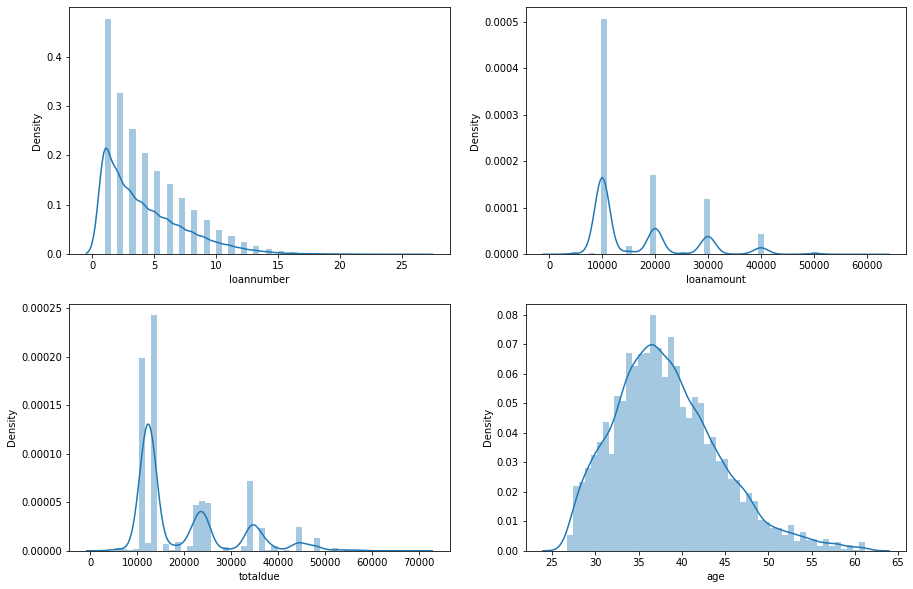

In [122]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = sns.distplot(numColumns['loannumber'])
#fig.set_ylabel('Loan number')

plt.subplot(2,2,2)
fig = sns.distplot(numColumns['loanamount'])
#fig.set_ylabel('Loan amount')

plt.subplot(2,2,3)
fig = sns.distplot(numColumns['totaldue'])
#fig.set_ylabel('Total due')

plt.subplot(2,2,4)
fig = sns.distplot(numColumns['age'])
#fig.set_ylabel('Age')

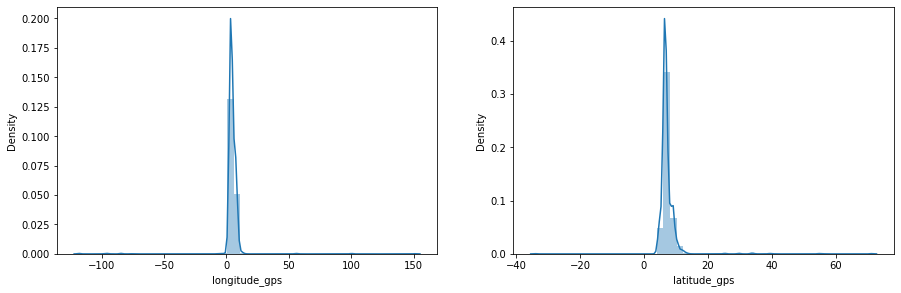

In [123]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = sns.distplot(numColumns['longitude_gps'])
#fig.set_ylabel('Loan number')

plt.subplot(2,2,2)
fig = sns.distplot(numColumns['latitude_gps'])
#fig.set_ylabel('Loan amount')

In [124]:
cols = X_train.columns

In [125]:
#Going to use a standard scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [126]:
X_train = pd.DataFrame(X_train, columns=[cols])
X_train

,loannumber,loanamount,totaldue,termdays,perf_loannumber,perf_loanamount,perf_totaldue,perf_termdays,longitude_gps,latitude_gps,...,Permanent,Retired,Self-Employed,Student,Unemployed,Graduate,No-Education-Level,Post-Graduate,Primary,Secondary
0,0.552386,-0.698799,-0.630206,0.292561,-0.094692,-1.241098,-1.219418,-0.224614,-0.133014,-0.054591,...,0.703183,-0.043859,-0.450888,-0.218176,-0.12677,2.111417,-1.725949,-0.180198,-0.049745,-0.188158
1,1.164202,1.440669,1.408708,0.292561,0.831318,1.130656,1.028384,-0.224614,-0.133511,-0.205081,...,0.703183,-0.043859,-0.450888,-0.218176,-0.12677,-0.473615,0.579391,-0.180198,-0.049745,-0.188158
2,-0.671247,-0.698799,-0.773121,-1.066263,-0.789200,-1.241098,-1.273801,-0.224614,0.142509,-0.496132,...,0.703183,-0.043859,-0.450888,-0.218176,-0.12677,-0.473615,0.579391,-0.180198,-0.049745,-0.188158
3,-0.365339,-0.698799,-0.773121,-1.066263,-0.094692,0.340071,0.339541,-0.224614,0.333803,0.471960,...,0.703183,-0.043859,-0.450888,-0.218176,-0.12677,2.111417,-1.725949,-0.180198,-0.049745,-0.188158
4,-0.059431,-0.698799,-0.630206,0.292561,-0.326195,-0.450513,-0.385556,-0.224614,-0.133063,-0.228978,...,0.703183,-0.043859,-0.450888,-0.218176,-0.12677,-0.473615,0.579391,-0.180198,-0.049745,-0.188158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10933,-0.977155,-0.698799,-0.630206,0.292561,-1.483708,-1.241098,-1.219418,-0.224614,0.326721,0.508486,...,0.703183,-0.043859,-0.450888,-0.218176,-0.12677,-0.473615,0.579391,-0.180198,-0.049745,-0.188158
10934,-0.365339,-0.698799,-0.630206,0.292561,-0.557697,-0.450513,-0.385556,-0.224614,-0.129992,-0.225268,...,0.703183,-0.043859,-0.450888,-0.218176,-0.12677,-0.473615,0.579391,-0.180198,-0.049745,-0.188158
10935,-0.059431,0.370935,0.398779,0.292561,0.368313,-0.450513,-0.494321,-0.224614,0.329962,0.537727,...,0.703183,-0.043859,-0.450888,-0.218176,-0.12677,-0.473615,0.579391,-0.180198,-0.049745,-0.188158
10936,1.470110,0.370935,0.379723,0.292561,1.062821,-0.450513,-0.566831,-0.224614,-0.122439,-0.239045,...,0.703183,-0.043859,-0.450888,-0.218176,-0.12677,-0.473615,0.579391,-0.180198,-0.049745,-0.188158


In [127]:
##### Dealing with imbalance data

## Logistic Regression
### with imbalanced data

In [128]:
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [129]:
y_pred_test = logreg.predict(X_test)

In [130]:
y_pred_test

array(['Good', 'Good', 'Good', ..., 'Good', 'Good', 'Good'], dtype=object)

In [131]:
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

Model accuracy score(test):  0.83327239488117


In [132]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

Model accuracy score(train):  0.811848601206802


In [133]:
y_test.value_counts()

Good    2275
Bad      460
Name: good_bad_flag, dtype: int64

In [134]:
null_acurracy = 2275/(len(y_test))

In [135]:
null_acurracy

0.8318098720292505

In [136]:
#confusion matrix
cm =confusion_matrix(y_test, y_pred_test)

In [137]:
cm

array([[  11,  449],
       [   7, 2268]])

In [138]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fd04ef6f190>,)

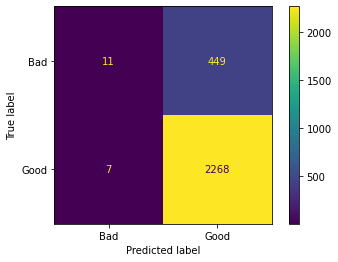

In [139]:
disp.plot(), 

In [140]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         Bad       0.61      0.02      0.05       460
        Good       0.83      1.00      0.91      2275

    accuracy                           0.83      2735
   macro avg       0.72      0.51      0.48      2735
weighted avg       0.80      0.83      0.76      2735



##### Dealing with imbalanced data

In [141]:
smote_algo = SMOTE(sampling_strategy='all',random_state=0)
smote_data_X, smote_data_Y = smote_algo.fit_resample(X_train,y_train)
smote_data_X = pd.DataFrame(data=smote_data_X, columns=X_train.columns)
smote_data_Y = pd.DataFrame(data=smote_data_Y, columns=['good_bad_flag'])

In [142]:
smote_data = smote_data_X
smote_data['good_bad_flag'] = smote_data_Y['good_bad_flag']

In [143]:
smote_data.drop_duplicates(keep="first", inplace=True) #removing duplicate data if any
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17742 entries, 0 to 17741
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (loannumber,)          17742 non-null  float64
 1   (loanamount,)          17742 non-null  float64
 2   (totaldue,)            17742 non-null  float64
 3   (termdays,)            17742 non-null  float64
 4   (perf_loannumber,)     17742 non-null  float64
 5   (perf_loanamount,)     17742 non-null  float64
 6   (perf_totaldue,)       17742 non-null  float64
 7   (perf_termdays,)       17742 non-null  float64
 8   (longitude_gps,)       17742 non-null  float64
 9   (latitude_gps,)        17742 non-null  float64
 10  (age,)                 17742 non-null  float64
 11  (loanlifewithdelta,)   17742 non-null  float64
 12  (LateFirstPay,)        17742 non-null  float64
 13  (EarlyFirstPay,)       17742 non-null  float64
 14  (Current,)             17742 non-null  float64
 15  (O

In [144]:
X = smote_data.drop(['good_bad_flag'],axis=1)
y = smote_data['good_bad_flag']

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 2)

In [146]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [147]:
X_train.shape, X_test.shape

((14193, 46), (3549, 46))

In [148]:
logreg = LogisticRegression(solver='liblinear', random_state=3)

In [149]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=3, solver='liblinear')

In [150]:
y_pred_test = logreg.predict(X_test)
y_pred_test

array(['Bad', 'Good', 'Good', ..., 'Bad', 'Good', 'Good'], dtype=object)

In [151]:
print('Model accuracy score(test): ', accuracy_score(y_test, y_pred_test))

Model accuracy score(test):  0.6297548605240912


In [152]:
y_pred_train = logreg.predict(X_train)

print('Model accuracy score(train): ', accuracy_score(y_train, y_pred_train))

Model accuracy score(train):  0.6328471781864299


In [153]:
y_test.value_counts()

(good_bad_flag,)
Bad                 1831
Good                1718
dtype: int64

In [154]:
null_acurracy = 1831/(len(y_test))

In [155]:
null_acurracy

0.515919977458439

In [156]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)

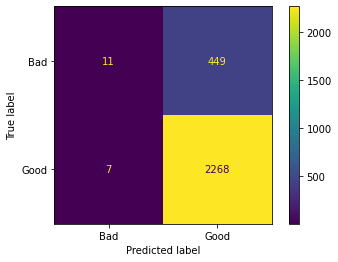

In [157]:
disp.plot()

In [158]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         Bad       0.63      0.67      0.65      1831
        Good       0.63      0.58      0.60      1718

    accuracy                           0.63      3549
   macro avg       0.63      0.63      0.63      3549
weighted avg       0.63      0.63      0.63      3549



In [159]:
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob

array([[0.50910874, 0.49089126],
       [0.29578713, 0.70421287],
       [0.37282486, 0.62717514],
       ...,
       [0.59116897, 0.40883103],
       [0.37817403, 0.62182597],
       [0.37746341, 0.62253659]])

In [160]:
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Probability of Good loan (0)',
                                                         'Probability of Bad loan (1)'])

y_pred_prob_df

,Probability of Good loan (0),Probability of Bad loan (1)
0,0.509109,0.490891
1,0.295787,0.704213
2,0.372825,0.627175
3,0.404038,0.595962
4,0.480122,0.519878
...,...,...
3544,0.599068,0.400932
3545,0.185204,0.814796
3546,0.591169,0.408831
3547,0.378174,0.621826


In [161]:
y_pred1 = logreg.predict_proba(X_test)[:,1]
y_pred0 = logreg.predict_proba(X_test)[:,0]

In [162]:
#plot ROC curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label='Good')

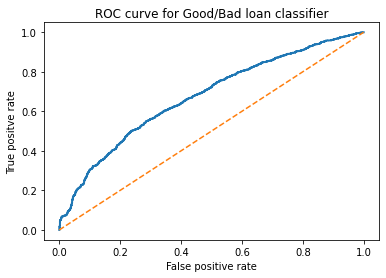

In [163]:
plt.figure(figsize = (6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], '--')
plt.title('ROC curve for Good/Bad loan classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positve rate')
plt.show()

In [164]:
#computing AUC 

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, y_pred1)

print(ROC_AUC)

0.6733758088132913


### K-nearest neighbours

In [165]:
knnr = KNeighborsRegressor(n_neighbors = 10)


In [166]:
knnr.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [167]:
format(np.power(y-knnr.predict(X),2).mean())

TypeError: unsupported operand type(s) for /: 'str' and 'int'